# Cataloging of different kinds of ANNs

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import *
from scipy.linalg import expm

### Initialize system and parameters

In [2]:
omega=1
gamma=1

ndelta=201
Deltamin=0
Deltamax=10
Deltalist=np.linspace(Deltamin,Deltamax,ndelta)
dDelta=Deltalist[1]-Deltalist[0]

dt=0.05
t0=0
tf=30
nt=int((tf-t0)/dt)
t=np.linspace(t0,tf,nt)

njumps=50
num_bins=50

Load photodetection registers and split them into 80% actual training data (80000 trajectories) and 20% validation (20000 trajectories)

In [3]:
delay_full=np.load("delay_full.npy")
histo_full=np.load("histo_full.npy")
delta_full=np.load("delta_full.npy")

delay_test=np.load("delay_test.npy")
histo_test=np.load("histo_test.npy")
delta_test=np.load("delta_test.npy")

In [14]:
delay_valid, delay_train=delay_full[:20000], delay_full[20000:]
histo_valid, histo_train=histo_full[:20000], histo_full[20000:]
delta_valid, delta_train=delta_full[:20000], delta_full[20000:]

In [4]:
Ntraj=10000
nu=100
nsets=int(Ntraj/nu)

#MLE method
T=np.zeros(Ntraj,float)
N=np.zeros(Ntraj,float)
for i in range(0,Ntraj):
    T[i]=np.sum(delay_test[i,:])
    N[i]=np.sum(histo_test[i,:])

Varclassiclist=np.zeros(nsets,float)
Deltaclassiclist=np.zeros(nsets,float)
Delta_set=np.zeros(nu,float)

for i in range(0,nsets):
    for j in range(0,nu):
        Delta_set[j]=0.5*np.sqrt((4*T[i*nu+j]*gamma*omega**2-8*N[i*nu+j]*omega**2-N[i*nu+j]*gamma**2)/N[i*nu+j])
        
    Deltaclassiclist[i]=np.sum(Delta_set)/nu
    Varclassiclist[i]=(Deltaclassiclist[i]-delta_test[0]*dDelta)**2

Sigmaclassiclist=np.sqrt(np.abs(Varclassiclist))
Deltaclassic=np.sum(Deltaclassiclist)/nsets   
Sigma_classic=np.sum(Sigmaclassiclist)/nsets

print("MLE=",Deltaclassic," +- ",Sigma_classic)

#Random estimation
P=1/ndelta
Rand_expect=np.sum(Deltalist*P)
Rand_squared=np.sum(Deltalist**2*P)
Rand_sigma=np.sqrt(np.abs(Rand_squared-Rand_expect**2))

print("Random=",Rand_expect," +- ",Rand_sigma)

MLE= 2.990588114861329  +-  0.022659039473509557
Random= 5.0  +-  2.9011491975882024


## Dense networks

### 1) Dense network  -   Input: histogram  - Output: classifier

In [16]:
model1=keras.models.Sequential()
model1.add(keras.layers.Dense(num_bins, activation="relu", input_shape=[num_bins]))
model1.add(keras.layers.Dense(84, activation="relu"))
model1.add(keras.layers.Dense(84, activation="relu"))
model1.add(keras.layers.Dense(ndelta, activation="softmax"))

model1.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 84)                4284      
                                                                 
 dense_2 (Dense)             (None, 84)                7140      
                                                                 
 dense_3 (Dense)             (None, 201)               17085     
                                                                 
Total params: 31,059
Trainable params: 31,059
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history=model1.fit(histo_train,delta_train,epochs=30,
                 validation_data=(histo_valid, delta_valid))

Epoch 1/30
2500/2500 [==============================] - 7s 2ms/step - loss: 3.8460 - accuracy: 0.0548 - val_loss: 3.7115 - val_accuracy: 0.0512
Epoch 2/30
2500/2500 [==============================] - 4s 2ms/step - loss: 3.5259 - accuracy: 0.0682 - val_loss: 3.6190 - val_accuracy: 0.0492
Epoch 3/30
2500/2500 [==============================] - 4s 2ms/step - loss: 3.4860 - accuracy: 0.0713 - val_loss: 3.5929 - val_accuracy: 0.0477
Epoch 4/30
2500/2500 [==============================] - 4s 2ms/step - loss: 3.4677 - accuracy: 0.0733 - val_loss: 3.5883 - val_accuracy: 0.0553
Epoch 5/30
2500/2500 [==============================] - 4s 2ms/step - loss: 3.4546 - accuracy: 0.0752 - val_loss: 3.5779 - val_accuracy: 0.0521
Epoch 6/30
2500/2500 [==============================] - 4s 2ms/step - loss: 3.4429 - accuracy: 0.0760 - val_loss: 3.5892 - val_accuracy: 0.0585
Epoch 7/30
2500/2500 [==============================] - 4s 2ms/step - loss: 3.4351 - accuracy: 0.0769 - val_loss: 3.6127 - val_accuracy:

In [37]:
model1.save("model_1.h5")

In [5]:
model1=keras.models.load_model("model_1.h5")

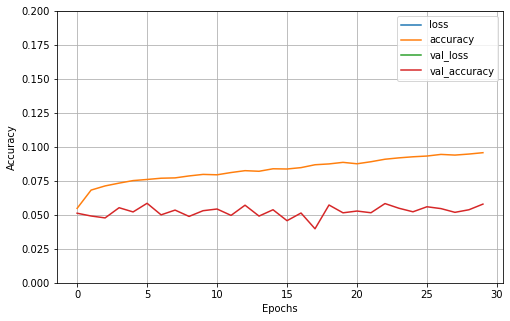

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.gca().set_ylim(0, 0.2) # set the vertical range to [0-1]

plt.show()

Delta= 2.9500000004940192  +-  0.04999999950598067


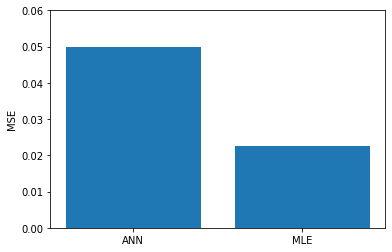

In [6]:
y_proba=model1.predict(histo_test)
y_proba=y_proba*20 #This factor avoids numerical overflowing due to really small numbers

Ntraj=10000
nu=100
nsets=int(Ntraj/nu)
Deltamean1=np.zeros(nsets,float)
Deltavar=np.zeros(nsets,float)

for i in range(0,nsets):
    Set=np.product(y_proba[i*nu:(i+1)*nu,:],0)
    Norma=np.sum(Set)
    Set=Set/Norma
    Deltamean1[i]=np.dot(Set,Deltalist)
    Deltavar[i]=(Deltamean1[i]-delta_test[0]*dDelta)**2

Delta_estimate=np.sum(Deltamean1)/nsets
Var=np.sum(Deltavar)/nsets
Delta_sigma1=np.sqrt(np.abs(Var))

print("Delta=",Delta_estimate," +- ",Delta_sigma1)

X=np.arange(2)
Error=[]
Error.append(Delta_sigma1)
Error.append(Sigma_classic)


plt.bar(X,Error)
plt.xticks(X, ("ANN", "MLE"))
#plt.title("Comparison between MSE")
plt.ylabel("MSE")
plt.ylim([0,0.06])
plt.show()    

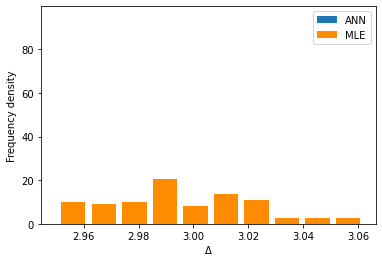

In [7]:
plt.hist(Deltamean1,align="left" , label="ANN", rwidth=0.8)
plt.hist(Deltaclassiclist, align="right", label="MLE",rwidth=0.8, color="darkorange", density=True)
plt.xlabel("\u0394")
plt.ylabel("Frequency density")
plt.legend()
#plt.title("Histogram with the predictions from "+str(nsets)+" sets")
plt.show()

### 2) Dense network  -   Input: histogram  - Output: single-neuron

In [41]:
model2=keras.models.Sequential()
model2.add(keras.layers.Dense(num_bins, activation="relu", input_shape=[num_bins]))
model2.add(keras.layers.Dense(17, activation="relu"))
model2.add(keras.layers.Dense(17, activation="relu"))
model2.add(keras.layers.Dense(1))

model2.compile(loss="mse",
             optimizer="adam",
             metrics=["MeanSquaredError"])

print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 17)                867       
                                                                 
 dense_14 (Dense)            (None, 17)                306       
                                                                 
 dense_15 (Dense)            (None, 1)                 18        
                                                                 
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
history=model2.fit(histo_train,delta_train*dDelta,epochs=30,
                 validation_data=(histo_valid, delta_valid*dDelta))

Epoch 1/30
2500/2500 [==============================] - 4s 1ms/step - loss: 1.5677 - mean_squared_error: 1.5677 - val_loss: 0.2671 - val_mean_squared_error: 0.2671
Epoch 2/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.2708 - mean_squared_error: 0.2708 - val_loss: 0.2501 - val_mean_squared_error: 0.2501
Epoch 3/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2556 - mean_squared_error: 0.2556 - val_loss: 0.2269 - val_mean_squared_error: 0.2269
Epoch 4/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2257 - val_mean_squared_error: 0.2257
Epoch 5/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2471 - mean_squared_error: 0.2471 - val_loss: 0.2176 - val_mean_squared_error: 0.2176
Epoch 6/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2429 - mean_squared_error: 0.2429 - val_loss: 0.2254 - val_mean_squared_error: 0.2254
Epoch 7/30
2500/

In [13]:
model2.save("model_2.h5")

In [8]:
model2=keras.models.load_model("model_2.h5")

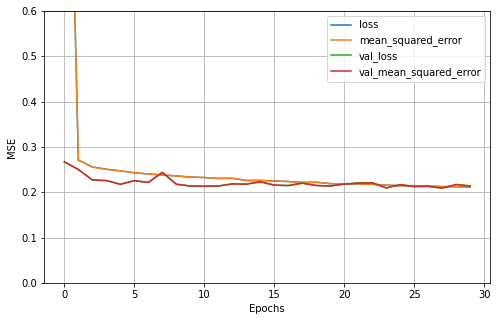

In [43]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
#plt.title("Performance")
plt.ylabel("MSE")
plt.grid(True)
plt.gca().set_ylim(0, 0.6) # set the vertical range to [0-1]
plt.show()

NN Delta= 2.9704235687255856  +-  0.03849813358655781


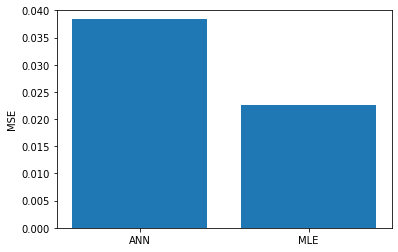

In [9]:
#Neural Network
y_proba=model2.predict(histo_test)

Ntraj=10000
nu=100
nsets=int(Ntraj/nu)
Deltamean2=np.zeros(nsets,float)
Deltavar=np.zeros(nsets,float)

for i in range(0,nsets):
    Deltamean2[i]=np.sum(y_proba[i*nu:(i+1)*nu])/nu
    Deltavar[i]=(Deltamean2[i]-delta_test[0]*dDelta)**2

Delta_estimate=np.sum(Deltamean2)/nsets
Var=np.sum(Deltavar)/nsets
Delta_sigma2=np.sqrt(np.abs(Var))

print("NN Delta=",Delta_estimate," +- ",Delta_sigma2)

X=np.arange(2)
Error=[]
Error.append(Delta_sigma2)
Error.append(Sigma_classic)


plt.bar(X,Error)
plt.xticks(X, ("ANN", "MLE"))
#plt.title("Comparison between MSE")
plt.ylabel("MSE")
plt.ylim([0,0.04])
plt.show()    

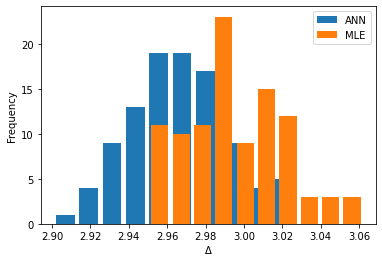

In [11]:
plt.hist(Deltamean2,align="left" , label="ANN", rwidth=0.8)
plt.hist(Deltaclassiclist, align="right", label="MLE",rwidth=0.8)
plt.xlabel("\u0394")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Recurrent networks

### 3) Recurrent network  -   Input: timedelays  - Output: classifier

In [12]:
model3=keras.models.Sequential()
model3.add(keras.Input(shape=(njumps,1)))
model3.add(keras.layers.LSTM(84, return_sequences=False, activation="relu"))
model3.add(keras.layers.Dense(ndelta,activation="softmax"))

model3.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

print(model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 84)                28896     
                                                                 
 dense (Dense)               (None, 201)               17085     
                                                                 
Total params: 45,981
Trainable params: 45,981
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history=model3.fit(delay_train,delta_train,epochs=30,
                 validation_data=(delay_valid, delta_valid))

Epoch 1/30
2500/2500 [==============================] - 59s 23ms/step - loss: 26240.3379 - accuracy: 0.0150 - val_loss: 7059.5674 - val_accuracy: 0.0098
Epoch 2/30
2500/2500 [==============================] - 57s 23ms/step - loss: 4552.8569 - accuracy: 0.0070 - val_loss: 3690.7637 - val_accuracy: 0.0054
Epoch 3/30
2500/2500 [==============================] - 56s 22ms/step - loss: 2305.2517 - accuracy: 0.0065 - val_loss: 1196.3770 - val_accuracy: 0.0057
Epoch 4/30
2500/2500 [==============================] - 56s 22ms/step - loss: 657.7784 - accuracy: 0.0104 - val_loss: 79.6679 - val_accuracy: 0.0078
Epoch 5/30
2500/2500 [==============================] - 56s 22ms/step - loss: 95.7182 - accuracy: 0.0146 - val_loss: 104.4026 - val_accuracy: 0.0117
Epoch 6/30
2500/2500 [==============================] - 56s 23ms/step - loss: 70.6095 - accuracy: 0.0173 - val_loss: 55.7034 - val_accuracy: 0.0132
Epoch 7/30
2500/2500 [==============================] - 57s 23ms/step - loss: 32.7197 - accuracy:

In [64]:
model3.save("model_3.h5")

In [16]:
model3=keras.models.load_model("model_3.h5")

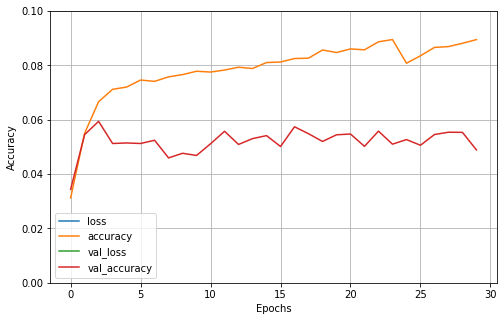

In [46]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
#plt.title("Performance")
plt.grid(True)
plt.ylabel("Accuracy")
plt.gca().set_ylim(0, 0.1) # set the vertical range to [0-1]
plt.show()

Delta= 2.937803612280317  +-  0.09478431405511976


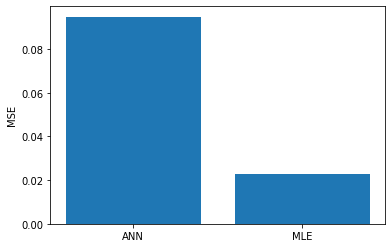

In [17]:
y_proba=model3.predict(delay_test)
y_proba=y_proba*10 #Factor to avoid numerical overflowing

Ntraj=10000
nu=100
nsets=int(Ntraj/nu)
Deltamean3=np.zeros(nsets,float)
Deltavar=np.zeros(nsets,float)

for i in range(0,nsets):
    Set=np.product(y_proba[i*nu:(i+1)*nu,:],0)
    Norma=np.sum(Set)
    Set=Set/Norma
    Deltamean3[i]=np.dot(Set,Deltalist)
    Deltavar[i]=(Deltamean3[i]-delta_test[0]*dDelta)**2

Delta_estimate=np.sum(Deltamean3)/nsets
Var=np.sum(Deltavar)/nsets
Delta_sigma3=np.sqrt(np.abs(Var))

print("Delta=",Delta_estimate," +- ",Delta_sigma3)

X=np.arange(2)
Error=[]
Error.append(Delta_sigma3)
Error.append(Sigma_classic)


plt.bar(X,Error)
plt.xticks(X, ("ANN", "MLE"))
plt.ylabel("MSE")
#plt.ylim([0,0.1])
plt.show()    

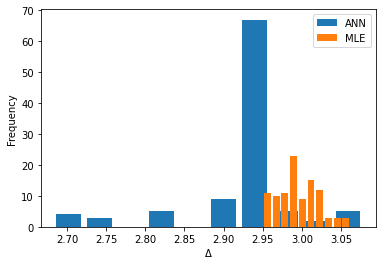

In [18]:
plt.hist(Deltamean3,align="left" , label="ANN", rwidth=0.8)
plt.hist(Deltaclassiclist, align="right", label="MLE",rwidth=0.8)
plt.xlabel("\u0394")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 4) Recurrent network  -   Input: time-delays  - Output: single-neuron

In [62]:
model4=keras.models.Sequential()
model4.add(keras.Input(shape=(njumps,1)))
model4.add(keras.layers.LSTM(17, return_sequences=True, activation="selu"))
model4.add(keras.layers.LSTM(17, return_sequences=False, activation="selu"))
model4.add(keras.layers.Dense(1))

model4.compile(loss="mse",
             optimizer="nadam",
             metrics=["MeanSquaredError"])

print(model4.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50, 17)            1292      
                                                                 
 lstm_6 (LSTM)               (None, 17)                2380      
                                                                 
 dense_19 (Dense)            (None, 1)                 18        
                                                                 
Total params: 3,690
Trainable params: 3,690
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
history=model4.fit(delay_train,delta_train*dDelta,epochs=30,
                 validation_data=(delay_valid, delta_valid*dDelta))

Epoch 1/30
2500/2500 [==============================] - 51s 20ms/step - loss: 4507.9326 - mean_squared_error: 4507.9326 - val_loss: 70.2860 - val_mean_squared_error: 70.2860
Epoch 2/30
2500/2500 [==============================] - 50s 20ms/step - loss: 39.7859 - mean_squared_error: 39.7859 - val_loss: 20.6783 - val_mean_squared_error: 20.6783
Epoch 3/30
2500/2500 [==============================] - 50s 20ms/step - loss: 18.9554 - mean_squared_error: 18.9554 - val_loss: 13.3336 - val_mean_squared_error: 13.3336
Epoch 4/30
2500/2500 [==============================] - 50s 20ms/step - loss: 9.1296 - mean_squared_error: 9.1296 - val_loss: 5.5562 - val_mean_squared_error: 5.5562
Epoch 5/30
2500/2500 [==============================] - 51s 20ms/step - loss: 3.7912 - mean_squared_error: 3.7912 - val_loss: 3.3867 - val_mean_squared_error: 3.3867
Epoch 6/30
2500/2500 [==============================] - 51s 20ms/step - loss: 2.2285 - mean_squared_error: 2.2285 - val_loss: 1.6691 - val_mean_squared_er

In [31]:
model4.save("model_4.h5")

In [19]:
model4=keras.models.load_model("model_4.h5")

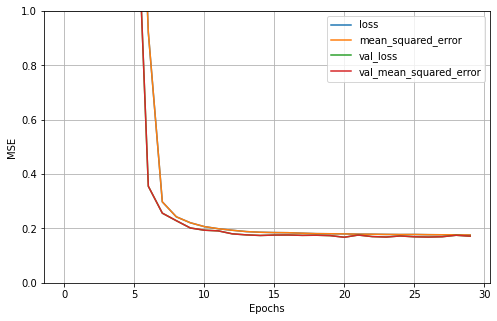

In [65]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
#plt.title("Performance")
plt.grid(True)
plt.ylabel("MSE")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Delta= 3.014226443481445  +-  0.026831207417529798


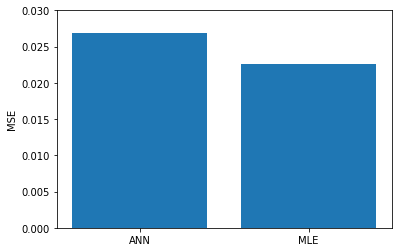

In [20]:
y_proba=model4.predict(delay_test)

Ntraj=10000
nu=100
nsets=int(Ntraj/nu)
Deltamean4=np.zeros(nsets,float)
Deltavar=np.zeros(nsets,float)

for i in range(0,nsets):
    Deltamean4[i]=np.sum(y_proba[i*nu:(i+1)*nu])/nu
    Deltavar[i]=(Deltamean4[i]-delta_test[0]*dDelta)**2

Delta_estimate=np.sum(Deltamean4)/nsets
Var=np.sum(Deltavar)/nsets
Delta_sigma4=np.sqrt(np.abs(Var))

print("Delta=",Delta_estimate," +- ",Delta_sigma4)

X=np.arange(2)
Error=[]
Error.append(Delta_sigma4)
Error.append(Sigma_classic)


plt.bar(X,Error)
plt.xticks(X, ("ANN", "MLE"))
plt.ylabel("MSE")
plt.ylim([0,0.03])
plt.show()    

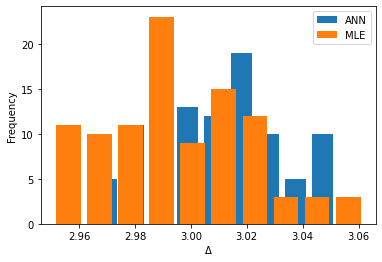

In [21]:
plt.hist(Deltamean4,align="left" , label="ANN", rwidth=0.8)
plt.hist(Deltaclassiclist, align="right", label="MLE",rwidth=0.8)
plt.xlabel("\u0394")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 5) Recurrent network  -   Input: histogram  - Output: classifier

In [11]:
model5=keras.models.Sequential()
model5.add(keras.Input(shape=(num_bins,1)))
model5.add(keras.layers.LSTM(32, return_sequences=True, activation="relu"))
model5.add(keras.layers.LSTM(16, return_sequences=False, activation="relu"))
model5.add(keras.layers.Dense(ndelta,activation="softmax"))

model5.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 201)               3417      
                                                                 
Total params: 10,905
Trainable params: 10,905
Non-trainable params: 0
_________________________________________________________________


In [12]:
history=model5.fit(histo_train,delta_train,epochs=30,
                 validation_data=(histo_valid, delta_valid))

Epoch 1/30
2500/2500 [==============================] - 53s 21ms/step - loss: 3.9716 - accuracy: 0.0477 - val_loss: 3.7000 - val_accuracy: 0.0421
Epoch 2/30
2500/2500 [==============================] - 54s 21ms/step - loss: 78.4163 - accuracy: 0.0614 - val_loss: 3.7067 - val_accuracy: 0.0481
Epoch 3/30
2500/2500 [==============================] - 54s 22ms/step - loss: 3.5211 - accuracy: 0.0660 - val_loss: 3.6614 - val_accuracy: 0.0398
Epoch 4/30
2500/2500 [==============================] - 52s 21ms/step - loss: 3.5135 - accuracy: 0.0682 - val_loss: 3.6217 - val_accuracy: 0.0576
Epoch 5/30
2500/2500 [==============================] - 52s 21ms/step - loss: 3.4994 - accuracy: 0.0684 - val_loss: 3.6287 - val_accuracy: 0.0457
Epoch 6/30
2500/2500 [==============================] - 54s 22ms/step - loss: 3.4960 - accuracy: 0.0703 - val_loss: 3.6076 - val_accuracy: 0.0553
Epoch 7/30
2500/2500 [==============================] - 56s 22ms/step - loss: 3.4916 - accuracy: 0.0692 - val_loss: 3.6427 

In [70]:
model5.save("model_5.h5")

In [22]:
model5=keras.models.load_model("model_5.h5")

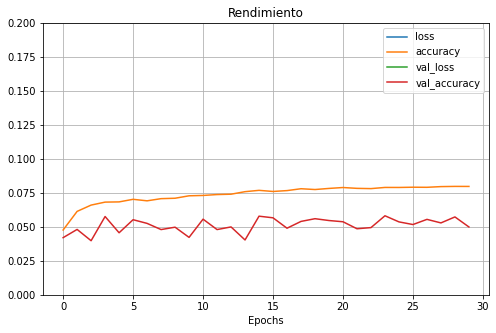

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Rendimiento")
plt.grid(True)
plt.gca().set_ylim(0, 0.2) # set the vertical range to [0-1]
plt.show()

Delta= 2.9500000015828216  +-  0.049999998417181314


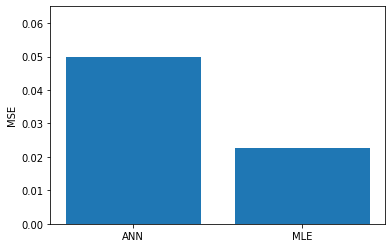

In [23]:
y_proba=model5.predict(histo_test)
y_proba=y_proba*20 #Factor to avoid numercial overflowing

Ntraj=10000
nu=100
nsets=int(Ntraj/nu)
Deltamean5=np.zeros(nsets,float)
Deltavar=np.zeros(nsets,float)

for i in range(0,nsets):
    Set=np.product(y_proba[i*nu:(i+1)*nu,:],0)
    Norma=np.sum(Set)
    Set=Set/Norma
    Deltamean5[i]=np.dot(Set,Deltalist)
    Deltavar[i]=(Deltamean5[i]-delta_test[0]*dDelta)**2

Delta_estimate=np.sum(Deltamean5)/nsets
Var=np.sum(Deltavar)/nsets
Delta_sigma5=np.sqrt(np.abs(Var))

print("Delta=",Delta_estimate," +- ",Delta_sigma5)

X=np.arange(2)
Error=[]
Error.append(Delta_sigma5)
Error.append(Sigma_classic)

plt.bar(X,Error)
plt.xticks(X, ("ANN", "MLE"))
plt.ylabel("MSE")
plt.ylim([0,0.065])
plt.show()    

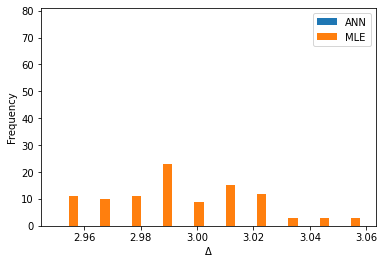

In [24]:
plt.hist(Deltamean5,align="left" , label="ANN", rwidth=0.8)
plt.hist(Deltaclassiclist, align="right", label="MLE",rwidth=0.3)
plt.xlabel("\u0394")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 6) Recurrent network  -   Input: absolute times  - Output: single-neuron

We need to make a little adjustment to our data to see the performance with absolute times instead of time-delays

In [26]:
abs_train=np.zeros([80000,njumps],float)
abs_valid=np.zeros([20000,njumps],float)
abs_test=np.zeros([10000,njumps],float)

abs_train[:,0]=delay_train[:,0] #First jump
abs_valid[:,0]=delay_valid[:,0] 
abs_test[:,0]=delay_test[:,0]

for i in range(0,80000):
    for j in range(1,njumps):
        abs_train[i,j]=abs_train[i,j-1]+delay_train[i,j]
        
for i in range(0,20000):
    for j in range(1,njumps):
        abs_valid[i,j]=abs_valid[i,j-1]+delay_valid[i,j]
        
for i in range(0,10000):
    for j in range(1,njumps):
        abs_test[i,j]=abs_test[i,j-1]+delay_test[i,j]


In [27]:
model6=keras.models.Sequential()
model6.add(keras.Input(shape=(njumps,1)))
model6.add(keras.layers.LSTM(20, return_sequences=False, activation="relu"))
model6.add(keras.layers.Dense(1))

model6.compile(loss="mse",
             optimizer="adam",
             metrics=["MeanSquaredError"])

print(model6.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                1760      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
history=model6.fit(abs_train,delta_train*dDelta,epochs=30,
                 validation_data=(abs_valid, delta_valid*dDelta))

Epoch 1/30
2500/2500 [==============================] - 27s 11ms/step - loss: 78006.9922 - mean_squared_error: 78006.9922 - val_loss: 71748.7734 - val_mean_squared_error: 71748.7734
Epoch 2/30
2500/2500 [==============================] - 30s 12ms/step - loss: 124130.1406 - mean_squared_error: 124130.1406 - val_loss: 62294.3984 - val_mean_squared_error: 62294.3984
Epoch 3/30
2500/2500 [==============================] - 28s 11ms/step - loss: 176916.6094 - mean_squared_error: 176916.6094 - val_loss: 154418.5156 - val_mean_squared_error: 154418.5156
Epoch 4/30
2500/2500 [==============================] - 27s 11ms/step - loss: 162061.3281 - mean_squared_error: 162061.3281 - val_loss: 58585.8242 - val_mean_squared_error: 58585.8242
Epoch 5/30
2500/2500 [==============================] - 27s 11ms/step - loss: 175065.0156 - mean_squared_error: 175065.0156 - val_loss: 297431.8438 - val_mean_squared_error: 297431.8438
Epoch 6/30
2500/2500 [==============================] - 27s 11ms/step - loss: 

In [26]:
model6.save("model_6.h5")

In [30]:
model6=keras.models.load_model("model_6.h5")

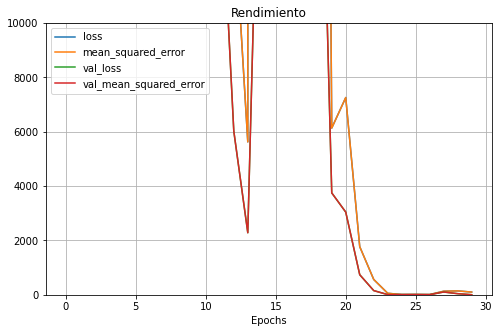

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Rendimiento")
plt.grid(True)
plt.gca().set_ylim(0, 10000) # set the vertical range to [0-1]
plt.show()

Delta= 3.2649150390624997  +-  0.26684121946191797


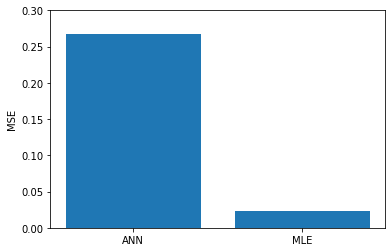

In [32]:
y_proba=model6.predict(abs_test)

Ntraj=10000
nu=100
nsets=int(Ntraj/nu)
Deltamean6=np.zeros(nsets,float)
Deltavar=np.zeros(nsets,float)

for i in range(0,nsets):
    Deltamean6[i]=np.sum(y_proba[i*nu:(i+1)*nu])/nu
    Deltavar[i]=(Deltamean6[i]-delta_test[0]*dDelta)**2

Delta_estimate=np.sum(Deltamean6)/nsets
Var=np.sum(Deltavar)/nsets
Delta_sigma6=np.sqrt(np.abs(Var))

print("Delta=",Delta_estimate," +- ",Delta_sigma6)

X=np.arange(2)
Error=[]
Error.append(Delta_sigma6)
Error.append(Sigma_classic)

plt.bar(X,Error)
plt.xticks(X, ("ANN", "MLE"))
plt.ylabel("MSE")
plt.ylim([0,0.3])
plt.show()    

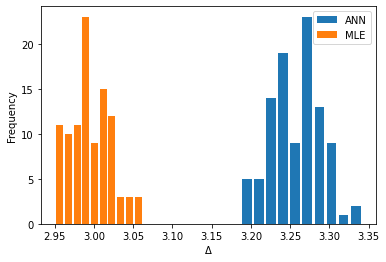

In [33]:
plt.hist(Deltamean6,align="left" , label="ANN", rwidth=0.8)
plt.hist(Deltaclassiclist, align="right", label="MLE",rwidth=0.8)
plt.xlabel("\u0394")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 7) Recurrent network  -   Input: absolute times  - Output: single-neuron

In [94]:
model7=keras.models.Sequential()
model7.add(keras.layers.Dense(num_bins, activation="relu", input_shape=[num_bins]))
model7.add(keras.layers.Dense(17, activation="relu"))
model7.add(keras.layers.Dense(17, activation="relu"))
model7.add(keras.layers.Dense(1))

model7.compile(loss="mse",
             optimizer="adam",
             metrics=["MeanSquaredError"])

print(model7.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 17)                867       
                                                                 
 dense_13 (Dense)            (None, 17)                306       
                                                                 
 dense_14 (Dense)            (None, 1)                 18        
                                                                 
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
history=model7.fit(abs_train,delta_train*dDelta,epochs=30,
                 validation_data=(abs_valid, delta_valid*dDelta))

Epoch 1/30
2500/2500 [==============================] - 4s 1ms/step - loss: 3194.8350 - mean_squared_error: 3194.8350 - val_loss: 18.2502 - val_mean_squared_error: 18.2502
Epoch 2/30
2500/2500 [==============================] - 3s 1ms/step - loss: 6.6243 - mean_squared_error: 6.6243 - val_loss: 1.1531 - val_mean_squared_error: 1.1531
Epoch 3/30
2500/2500 [==============================] - 3s 1ms/step - loss: 1.7941 - mean_squared_error: 1.7941 - val_loss: 1.3341 - val_mean_squared_error: 1.3341
Epoch 4/30
2500/2500 [==============================] - 3s 1ms/step - loss: 2.0175 - mean_squared_error: 2.0175 - val_loss: 1.3585 - val_mean_squared_error: 1.3585
Epoch 5/30
2500/2500 [==============================] - 3s 1ms/step - loss: 1.5930 - mean_squared_error: 1.5930 - val_loss: 3.3218 - val_mean_squared_error: 3.3218
Epoch 6/30
2500/2500 [==============================] - 3s 1ms/step - loss: 1.8512 - mean_squared_error: 1.8512 - val_loss: 1.2032 - val_mean_squared_error: 1.2032
Epoch 7/

In [96]:
model7.save("model_7.h5")

In [35]:
model7=keras.models.load_model("model_7.h5")

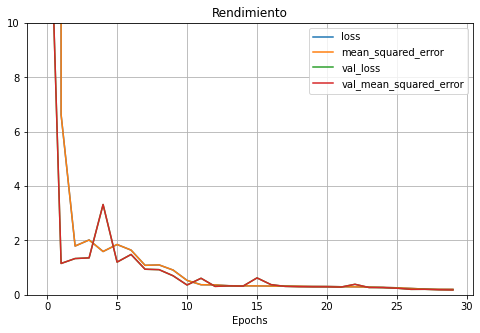

In [97]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Rendimiento")
plt.grid(True)
plt.gca().set_ylim(0, 10) # set the vertical range to [0-1]
plt.show()

Delta= 2.9561382812500003  +-  0.05026022953932933


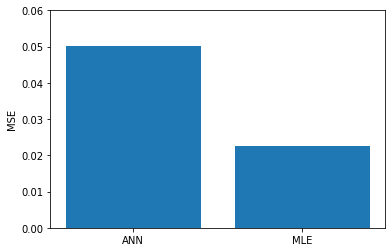

In [37]:
y_proba=model7.predict(abs_test)

Ntraj=10000
nu=100
nsets=int(Ntraj/nu)
Deltamean7=np.zeros(nsets,float)
Deltavar=np.zeros(nsets,float)

for i in range(0,nsets):
    Deltamean7[i]=np.sum(y_proba[i*nu:(i+1)*nu])/nu
    Deltavar[i]=(Deltamean7[i]-delta_test[0]*dDelta)**2

Delta_estimate=np.sum(Deltamean7)/nsets
Var=np.sum(Deltavar)/nsets
Delta_sigma7=np.sqrt(np.abs(Var))

print("Delta=",Delta_estimate," +- ",Delta_sigma7)

X=np.arange(2)
Error=[]
Error.append(Delta_sigma7)
Error.append(Sigma_classic)

plt.bar(X,Error)
plt.xticks(X, ("ANN", "MLE"))
plt.ylabel("MSE")
plt.ylim([0,0.06])
plt.show() 

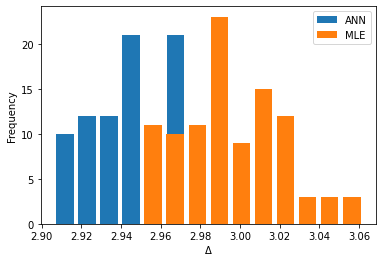

In [38]:
plt.hist(Deltamean7,align="left" , label="ANN", rwidth=0.8)
plt.hist(Deltaclassiclist, align="right", label="MLE",rwidth=0.8)
plt.xlabel("\u0394")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 8) Dense network  -   Input: time-delays  - Output: single-output

In [31]:
model8=keras.models.Sequential()
model8.add(keras.layers.Dense(num_bins, activation="relu", input_shape=[num_bins]))
model8.add(keras.layers.Dense(17, activation="relu"))
model8.add(keras.layers.Dense(17, activation="relu"))
model8.add(keras.layers.Dense(1))

model8.compile(loss="mse",
             optimizer="adam",
             metrics=["MeanSquaredError"])

print(model8.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 17)                867       
                                                                 
 dense_4 (Dense)             (None, 17)                306       
                                                                 
 dense_5 (Dense)             (None, 1)                 18        
                                                                 
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
history=model8.fit(delay_train,delta_train*dDelta,epochs=30,
                 validation_data=(delay_valid, delta_valid*dDelta))

Epoch 1/30
2500/2500 [==============================] - 4s 1ms/step - loss: 3.0623 - mean_squared_error: 3.0623 - val_loss: 1.0332 - val_mean_squared_error: 1.0332
Epoch 2/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.8918 - mean_squared_error: 0.8918 - val_loss: 0.7233 - val_mean_squared_error: 0.7233
Epoch 3/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4826 - mean_squared_error: 0.4826 - val_loss: 0.2960 - val_mean_squared_error: 0.2960
Epoch 4/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2739 - mean_squared_error: 0.2739 - val_loss: 0.2325 - val_mean_squared_error: 0.2325
Epoch 5/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2506 - mean_squared_error: 0.2506 - val_loss: 0.2277 - val_mean_squared_error: 0.2277
Epoch 6/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2393 - mean_squared_error: 0.2393 - val_loss: 0.2303 - val_mean_squared_error: 0.2303
Epoch 7/30
2500/

In [33]:
model8.save("model_8.h5")

In [39]:
model8=keras.models.load_model("model_8.h5")

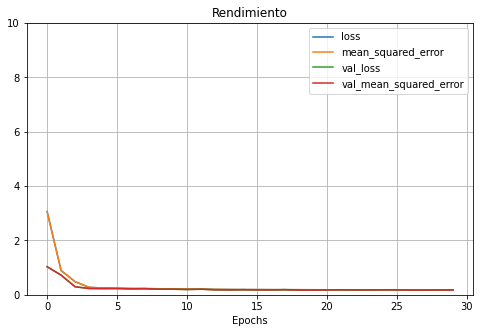

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Rendimiento")
plt.grid(True)
plt.gca().set_ylim(0, 10) # set the vertical range to [0-1]
plt.show()

Delta= 2.9850547851562492  +-  0.032166131334602235


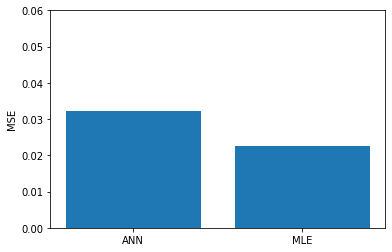

In [40]:
y_proba=model8.predict(delay_test)

Ntraj=10000
nu=100
nsets=int(Ntraj/nu)
Deltamean8=np.zeros(nsets,float)
Deltavar=np.zeros(nsets,float)

for i in range(0,nsets):
    Deltamean8[i]=np.sum(y_proba[i*nu:(i+1)*nu])/nu
    Deltavar[i]=(Deltamean8[i]-delta_test[0]*dDelta)**2

Delta_estimate=np.sum(Deltamean8)/nsets
Var=np.sum(Deltavar)/nsets
Delta_sigma8=np.sqrt(np.abs(Var))

print("Delta=",Delta_estimate," +- ",Delta_sigma8)

X=np.arange(2)
Error=[]
Error.append(Delta_sigma8)
Error.append(Sigma_classic)

plt.bar(X,Error)
plt.xticks(X, ("ANN", "MLE"))
plt.ylabel("MSE")
plt.ylim([0,0.06])
plt.show() 

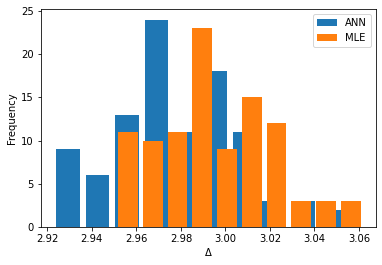

In [42]:
plt.hist(Deltamean8,align="left" , label="ANN", rwidth=0.8)
plt.hist(Deltaclassiclist, align="right", label="MLE",rwidth=0.8)
plt.xlabel("\u0394")
plt.ylabel("Frequency")
plt.legend()
plt.show()